In [ ]:
import torch

model_path = "debug/20230607172037/spectral_fc_01.pth"
dict = torch.load(model_path, map_location=torch.device('cpu'))
print("epoch",dict['epoch'])
for k, v in dict["state_dict"].items():
    print(k, v)


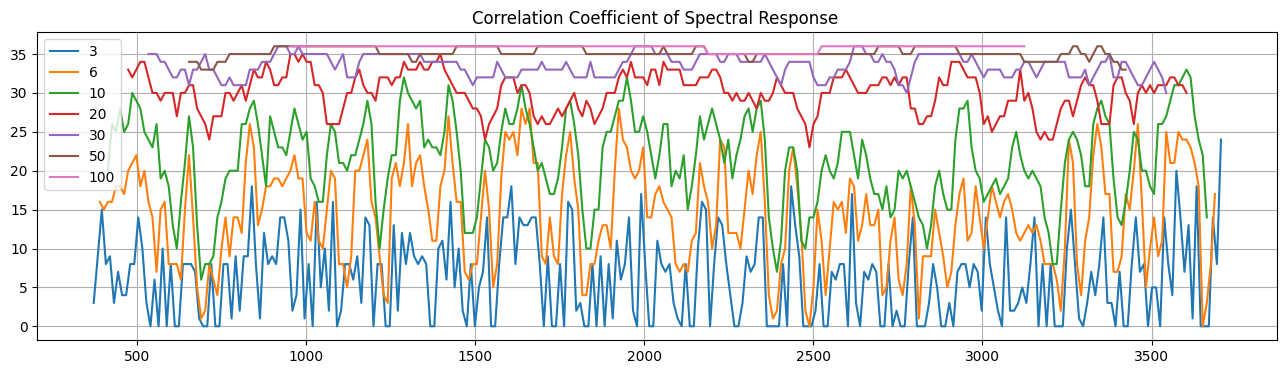

In [80]:
import numpy as np
import matplotlib.pylab as plt

sp_file ="data/SpectralResponse_9.npy" 
sp = np.load(sp_file)
sz = sp.shape

thresh = 0.8
plt.figure()
plt.rcParams['figure.figsize'] = (16, 4) 
lens = [3, 6, 10,20,30,50,100]
for len in lens:
    x = list()
    y = list()
    for i in range(sz[0] - len):
        coff = np.corrcoef(sp[i:i+len,:],rowvar=False)
        count = np.count_nonzero(np.abs(coff)<thresh)
        x.append((i + len/2) * (3735-355) / sz[0] + 355)
        y.append(count/2)
    # y = y / np.max(y)
    plt.plot(x,y,'-')
plt.title("Correlation Coefficient of Spectral Response ")
plt.grid()
plt.legend(lens)
plt.show()


In [ ]:

from dataset.SpectralDataset import SpectralDataset
from net.model_LADMM import LADMM
import torch
import matplotlib.pylab as plt
import random
import collections
import numpy as np

sp_file ="data/SpectralResponse_9.npy"   
admm = LADMM(mode="l1_tv_cnn", sp_file = sp_file, iter = 50)

sp = np.load(sp_file)
length, det_num = sp.shape
print(length, det_num)

model_path = "debug/20230608102342/spectral_fc_01.pth"
dict = torch.load(model_path, map_location=torch.device('cpu'))
print("epoch",dict['epoch'])
new_state_dict = collections.OrderedDict()
for k, v in dict["state_dict"].items():
    name = k[7:] # remove 'module.' prefix
    new_state_dict[name] = v
admm.load_state_dict(new_state_dict)
admm.eval()

plt.rcParams['figure.figsize'] = (16, 8.0) 
sigs = [30,35,40,45,50, 55]
col = len(sigs)//2

plt.figure()
fig, ax = plt.subplots(2,col)
for i in range(2):
    for j in range(col):
        idx = i * col + j

        dataset = SpectralDataset(sp_file, train=True, have_noise=False, sig=(sigs[idx],sigs[idx]+1), peak_num=5)
        det, spectral = dataset.__getitem__(1)
        sz = dataset.get_size()
        x = torch.linspace(355,3735,sz[0])
        with torch.no_grad():
            rex = admm.forward(det.unsqueeze(0), spectral.unsqueeze(0))
        ax[i][j].plot(x, spectral,'b', x, rex.squeeze(0).detach(),'r:') 
        ax[i][j].set_title("sigma:{}".format(sigs[idx]))  
plt.show()